In [4]:
import torch
import numpy as np
from torch_geometric.utils import to_edge_index
import matplotlib.pyplot as plt
import networkx as nx
from utils.data import get_data
from networks.VAEs import VAE, Params_VAE
import snf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
METABRIC_PATH = "./data/MBdata_33CLINwMiss_1KfGE_1KfCNA.csv"
metabric = get_data(METABRIC_PATH)


def load_adj(path, normalise=True):
    X = np.genfromtxt(path, delimiter=",")
    np.fill_diagonal(X, 0)
    if normalise:
        X = (X - X.min()) / (X.max() - X.min())
    return X


def get_edge_index(X, threshold=None, N_largest=None):
    if N_largest:
        idx = np.argpartition(X.ravel(), -N_largest * 2)[-N_largest * 2 :]
        threshold = X.ravel()[idx].min()

    if threshold:
        X[X < threshold] = 0

    return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))


def print_hist(edge_attr):
    plt.hist(edge_attr, log=True, ec="black")
    plt.xlabel("Normalised distance value")
    plt.ylabel("Counts (log)")
    plt.show()


def min_max_normalisation(X):
    return (X - X.min()) / (X.max() - X.min())


def print_graph(edge_index, labels):
    H = nx.Graph()
    H.add_nodes_from(np.unique(edge_index.flatten()))
    edges = [(int(e[0]), int(e[1])) for e in zip(edge_index[0], edge_index[1])]
    H.add_edges_from(edges)

    G = nx.Graph()
    G.add_nodes_from(sorted(H.nodes(data=True)))
    G.add_edges_from(H.edges(data=True))

    nx.draw_networkx(
        G,
        with_labels=False,
        # node_color=labels[np.array(G.nodes())].tolist(),
        node_color=labels,
        node_size=1,
        width=0.25,
    )
    # nx.draw_networkx(G, with_labels=False, node_size=1, width=0.25)

    print("Total number of nodes: ", int(G.number_of_nodes()))
    print("Total number of edges: ", int(G.number_of_edges()))
    print("Max Degree for all nodes: ", np.array(G.degree())[:, 1].max())

    print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))

    return G

ModuleNotFoundError: No module named 'utils'

In [5]:
c = np.genfromtxt("./data/SNF/fold_1/snf_CLI_CNA_latent.csv", delimiter=",")
c

array([[0.        , 0.00047536, 0.00043903, ..., 0.00042511, 0.00054994,
        0.00046892],
       [0.00047536, 0.        , 0.00045154, ..., 0.00041906, 0.00047021,
        0.00045196],
       [0.00043903, 0.00045154, 0.        , ..., 0.00042505, 0.00043747,
        0.00043885],
       ...,
       [0.00042511, 0.00041906, 0.00042505, ..., 0.        , 0.00044646,
        0.00045857],
       [0.00054994, 0.00047021, 0.00043747, ..., 0.00044646, 0.        ,
        0.00059382],
       [0.00046892, 0.00045196, 0.00043885, ..., 0.00045857, 0.00059382,
        0.        ]])

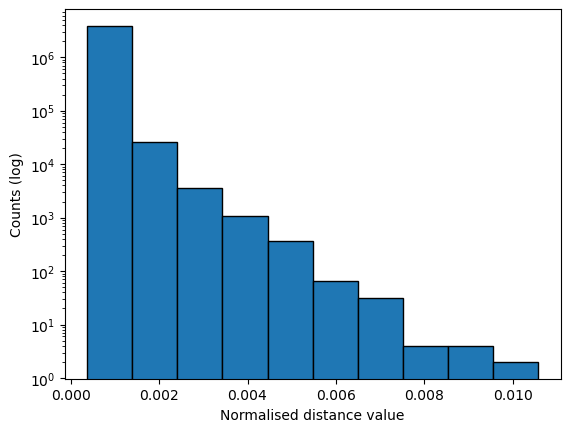

In [6]:
e_i_rna, e_a_rna = get_edge_index(c)
print_hist(e_a_rna)

In [12]:
labels = np.array(metabric["pam50"]).tolist()

color_codes = {
    "LumA":"tab:red",
    "LumB":"tab:pink",
    "Normal":"tab:green",
    "Basal":"tab:blue",
    "Her2":"tab:brown"}

color_labels = np.array([color_codes[l] for l in labels])


Total number of nodes:  1416
Total number of edges:  3000
Max Degree for all nodes:  28
Total number of self-loops:  0


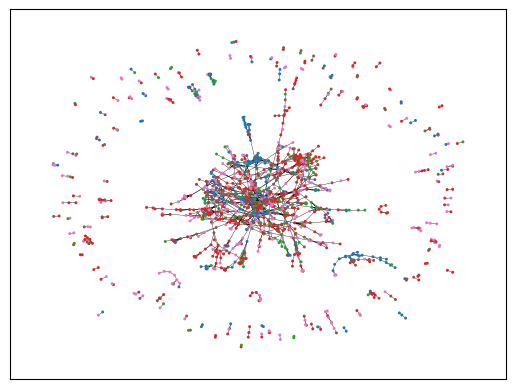

In [16]:
c = np.genfromtxt("./data/SNF/snf_CLI_RNA.csv", delimiter=",")
np.fill_diagonal(c,0)
edge_index, e_a = get_edge_index(c, N_largest=3000)
H = nx.Graph()
H.add_nodes_from(np.unique(edge_index.flatten()))
edges = [(int(e[0]), int(e[1])) for e in zip(edge_index[0], edge_index[1])]
H.add_edges_from(edges)

G = nx.Graph()
G.add_nodes_from(sorted(H.nodes(data=True)))
G.add_edges_from(H.edges(data=True))

nx.draw_networkx(
    G,
    with_labels=False,
    node_color=color_labels[np.array(G.nodes())].tolist(),
    node_size=5,
    node_shape=".",
    width=0.25,
)

print("Total number of nodes: ", int(G.number_of_nodes()))
print("Total number of edges: ", int(G.number_of_edges()))
print("Max Degree for all nodes: ", np.array(G.degree())[:, 1].max())

print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))

In [2]:
metabric = get_data(METABRIC_PATH)

labels = np.array(metabric["pam50"])
labels[labels == "LumA"] = "#ff0000"
labels[labels == "LumB"] = "#ff00ff"
labels[labels == "Normal"] = "#ffff00"
labels[labels == "Basal"] = "#3366ff"
labels[labels == "Her2"] = "#33cc33"

In [20]:
omics_names = ["CLI", "RNA", "CNA"]
latents = {}
latent_sim = {}
for name in omics_names:
    input_dim = 1000
    if name == "CLI":
        input_dim = 350

    dense_dim = 256
    latent_dim = 128

    vae_path = f"../IntegrativeVAE/results/VAE_{name}/0122141739/fold_1/VAE.pth"

    vae_params = Params_VAE(input_dim, dense_dim, latent_dim)
    vae = VAE(vae_params)
    vae.load_state_dict(torch.load(vae_path))
    vae.eval()
    vae.to(DEVICE)

    _, _, _, _, z = vae.forward(torch.tensor(metabric[name], dtype=torch.float32))
    latents[name] = z.detach().cpu().numpy()

    temp = np.corrcoef(latents[name])
    np.fill_diagonal(temp, 0)
    latent_sim[name] = temp

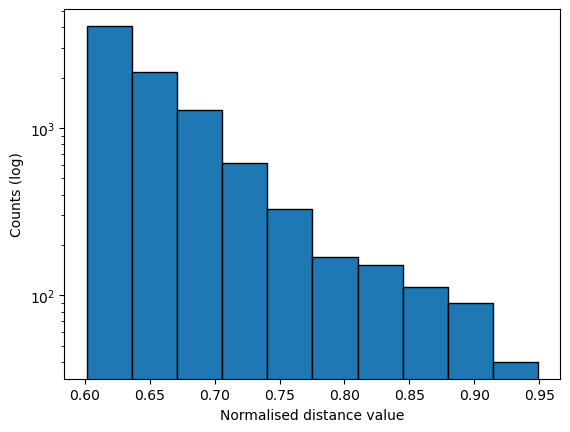

Total number of nodes:  1308
Total number of edges:  4500
Max Degree for all nodes:  45
Total number of self-loops:  0


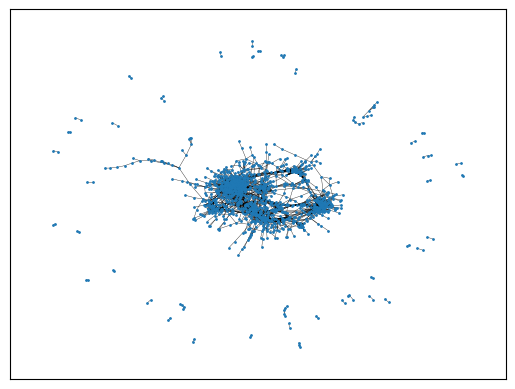

In [22]:
e_i_rna, e_a_rna = get_edge_index(latent_sim["RNA"], N_largest=4500)
print_hist(e_a_rna)
print_graph(e_i_rna)

In [24]:
e_i_rna

tensor([[   1,    1,    1,  ..., 1971, 1972, 1972],
        [   2,    4,    6,  ...,  233,   97, 1959]])

In [78]:
edge_indices = []
edge_attributes = []
for name in ["CLI", "RNA"]:
    e_i, e_a = get_edge_index(latent_sim[name], N_largest=4500)
    edge_indices.append(e_i)
    edge_attributes.append(e_a)

edge_index_comb = [[],[]]
edge_attr_comb = []
for i in range(len(edge_indices[0][0])):
    if(edge_indices[0][0][i]==edge_indices[1][0][i]) & (edge_indices[0][1][i]==edge_indices[1][1][i]):
        print("a")
    else:
        for n in range(2):
            edge_index_comb[0].append(edge_indices[n][0][i])
            edge_index_comb[1].append(edge_indices[n][1][i])
            edge_attr_comb.append(n)

edge_index_comb = torch.tensor(edge_index_comb)
edge_attr_comb = torch.tensor(edge_attr_comb)

In [79]:
edge_index_comb

tensor([[   0,    1,    0,  ..., 1972, 1971, 1972],
        [ 549,    2,  586,  ...,   97, 1541, 1959]])

In [80]:
edge_attr_comb

tensor([0, 1, 0,  ..., 1, 0, 1])

In [61]:
len(edge_indices[0][1])

9000

In [25]:
e_i_cli, e_a_cli = get_edge_index(latent_sim["CLI"], N_largest=4500)
e_i_cli

tensor([[   0,    0,    0,  ..., 1971, 1971, 1971],
        [ 549,  586,  706,  ...,  482, 1140, 1541]])

In [40]:
e = (torch.tensor(1),torch.tensor(1))
n = (torch.tensor(1),torch.tensor(1))
e == n

True

In [55]:
list_cli = list(zip(e_i_cli[0],e_i_cli[1]))
list_rna = list(zip(e_i_rna[0],e_i_rna[1]))

# t_c = [[1,2,3],[4,4,4]]
# t_r = [[1,2,3],[4,1,1]]

# list_cli = list(zip(t_c[0],t_c[1]))
# list_rna = list(zip(t_r[0],t_r[1]))

e_a_comb = []
e_i_comb_1 = []
e_i_comb_2 = []
for i in range(len(list_cli)):
    if list_cli[i]==list_rna[i]:
        print("a")
        # e_a_comb
    else:
        e_i_comb_1.append(int(list_cli[i][0]))
        e_i_comb_2.append(int(list_cli[i][1]))

        e_a_comb.append(0)

        e_i_comb_1.append(int(list_rna[i][0]))
        e_i_comb_2.append(int(list_rna[i][1]))

        e_a_comb.append(1)



In [53]:
len(torch.tensor([e_i_comb_1,e_i_comb_2]))

18000

In [56]:
torch.tensor(e_a_comb)

tensor([0, 1, 0,  ..., 1, 0, 1])

In [16]:
c = np.corrcoef(latents["RNA"])
np.fill_diagonal(c,0)
c

array([[ 0.        ,  0.30413118,  0.11802054, ...,  0.33741092,
        -0.06136601,  0.08827021],
       [ 0.30413118,  0.        ,  0.5948033 , ...,  0.01132687,
        -0.05760606, -0.00222942],
       [ 0.11802054,  0.5948033 ,  0.        , ...,  0.03530365,
         0.10745423,  0.17394413],
       ...,
       [ 0.33741092,  0.01132687,  0.03530365, ...,  0.        ,
        -0.00063943,  0.21271735],
       [-0.06136601, -0.05760606,  0.10745423, ..., -0.00063943,
         0.        ,  0.06369366],
       [ 0.08827021, -0.00222942,  0.17394413, ...,  0.21271735,
         0.06369366,  0.        ]])

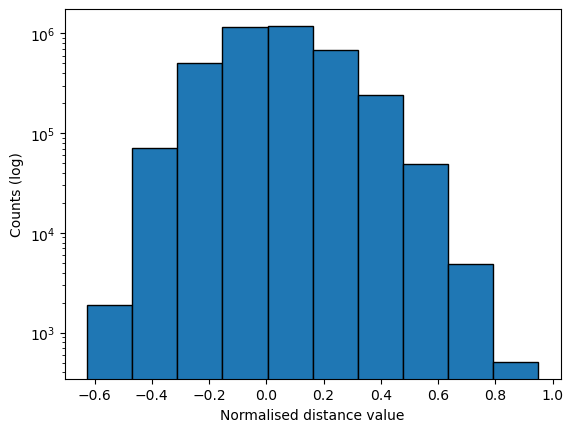

In [13]:
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1820
Total number of edges:  14000
Max Degree for all nodes:  100
Total number of self-loops:  0


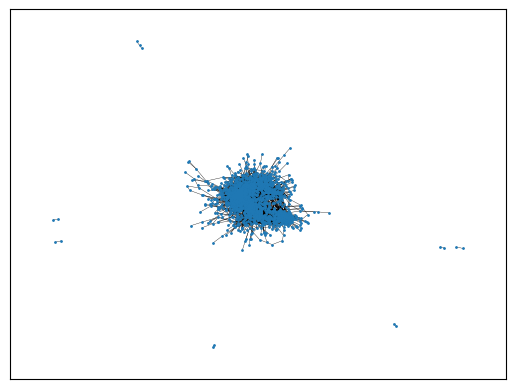

In [17]:
edge_index, edge_attr = get_edge_index(c, N_largest=14000)
print_graph(edge_index)

In [ ]:
snf_cli = gw.gower_matrix(metabric["CLI"]) 
snf_rna = np.corrcoef(metabric["RNA"])

In [20]:
len(latent_sim)

3

In [23]:
snf_all = snf.compute.snf(latent_sim, K=20)
np.fill_diagonal(snf_all,0)

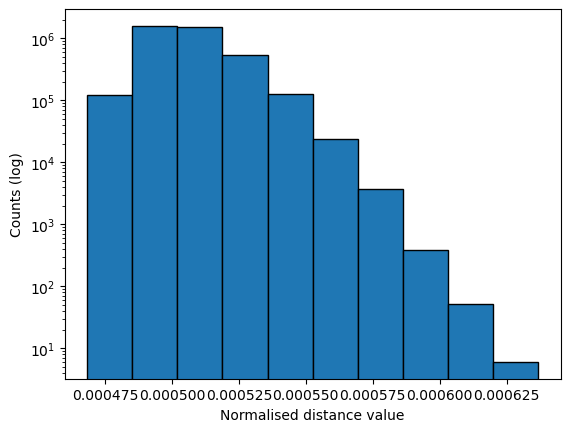

In [24]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1974
Total number of edges:  30000
Max Degree for all nodes:  59
Total number of self-loops:  0


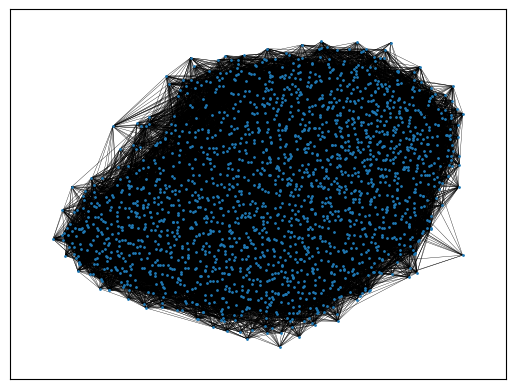

In [29]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c, N_largest=30000)
print_graph(edge_index)

# CLI

In [7]:
snf_cli = snf.make_affinity(latents["CLI"], metric="euclidean", K=5)
np.fill_diagonal(snf_cli,0)
snf_cli = min_max_normalisation(snf_cli)

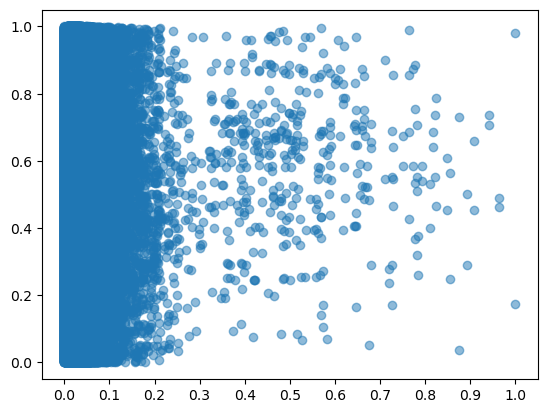

In [8]:
x = [k[0] for k in snf_cli.reshape(-1, 1).tolist()]
y = np.linspace(0, 1, len(x))

plt.scatter(x, y, alpha=0.5)
plt.xticks([i / 10 for i in range(11)])
plt.show()

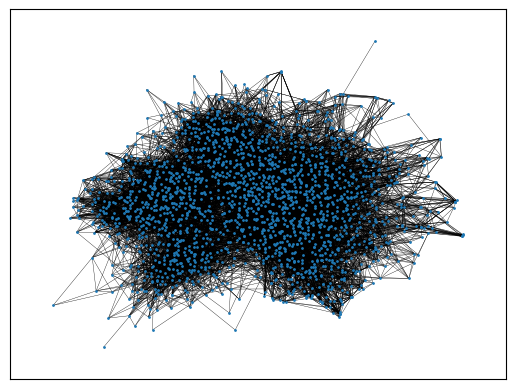

In [37]:
X = snf_cli.copy()
X[X < 0.05] = 0
edge_index, _ =  to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))
G = print_graph(edge_index)

# CLI+RNA+CNA

In [26]:
K = 20
adj_all = snf.make_affinity([latents["CLI"], latents["CNA"], latents["RNA"]], metric="correlation", K=K)
# adj_all = [min_max_normalisation(adj) for adj in adj_all]
snf_all = snf.compute.snf(adj_all, K=K)
# snf_all = min_max_normalisation(snf_all)
np.fill_diagonal(snf_all, 0)

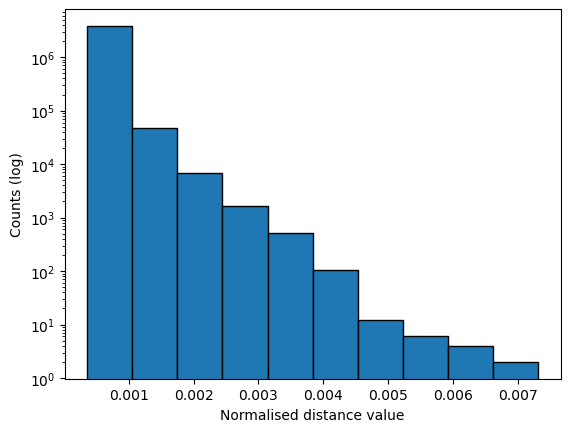

In [30]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c)
print_hist(edge_attr)

Total number of nodes:  1960
Total number of edges:  7000
Max Degree for all nodes:  30
Total number of self-loops:  0


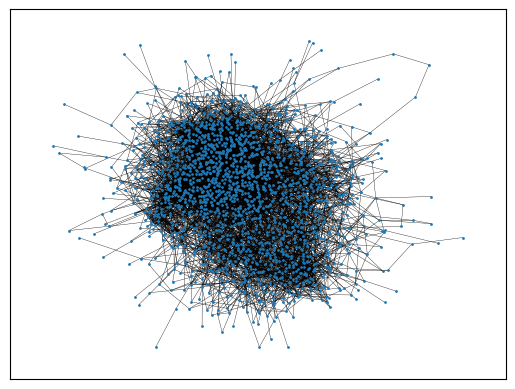

In [32]:
c = snf_all.copy()
edge_index, edge_attr = get_edge_index(c, N_largest=7000)
print_graph(edge_index)